# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.852457,False,0.090386
1,-0.006110,False,1.315806
2,0.753796,True,5.396246
3,0.048604,True,5.363062
4,2.093125,True,5.523282
...,...,...,...
995,-0.182264,False,0.026446
996,0.868758,True,3.733600
997,-0.075007,False,-0.399839
998,0.425207,True,4.613833


<Axes: xlabel='v0'>

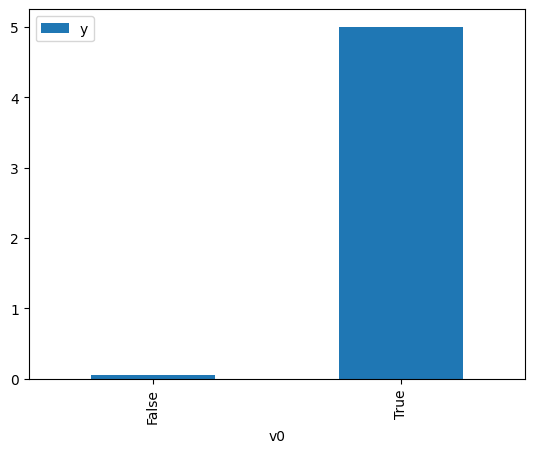

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

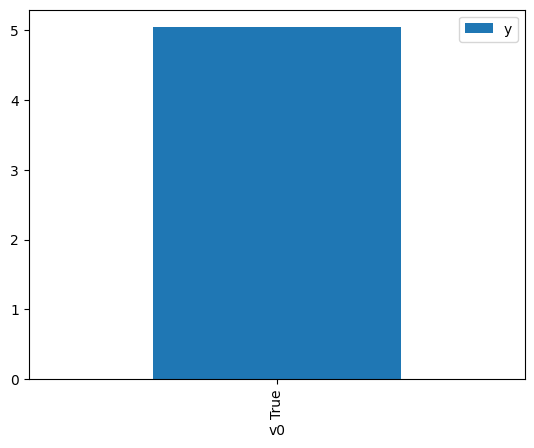

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.899418,False,0.366305,0.033302,30.027820
1,0.834383,False,0.769089,0.188048,5.317794
2,1.456841,False,0.803144,0.070672,14.149922
3,1.456841,False,0.803144,0.070672,14.149922
4,0.753303,False,1.079335,0.211205,4.734742
...,...,...,...,...,...
995,0.834383,False,0.769089,0.188048,5.317794
996,1.442704,False,0.625055,0.072351,13.821492
997,-0.584392,False,-1.562252,0.745672,1.341072
998,0.670976,False,-0.420100,0.236786,4.223231


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.783967,True,5.041217,0.797791,1.253462
1,0.712328,True,6.050485,0.776324,1.288123
2,-0.044333,True,4.978843,0.472674,2.115622
3,-1.873344,True,5.908439,0.032869,30.423452
4,0.722298,True,5.047403,0.779406,1.283029
...,...,...,...,...,...
995,0.904886,True,5.035032,0.830459,1.204153
996,0.730687,True,5.109867,0.781975,1.278813
997,1.590908,True,5.427140,0.943549,1.059828
998,-0.621299,True,2.427903,0.242010,4.132068


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.945
Model:                            OLS   Adj. R-squared (uncentered):              0.945
Method:                 Least Squares   F-statistic:                              8511.
Date:                Wed, 15 Nov 2023   Prob (F-statistic):                        0.00
Time:                        21:24:47   Log-Likelihood:                         -1387.4
No. Observations:                1000   AIC:                                      2779.
Df Residuals:                     998   BIC:                                      2789.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0307      0.037      0.841      0.400      -0.041       0.102
x2             4.9966      0.052     96.541      0.000       4.895       5.098
==============================================================================
Omnibus:                        1.280   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.527   Jarque-Bera (JB):                1.162
Skew:                           0.037   Prob(JB):                        0.559
Kurtosis:                       3.150   Cond. No.                         2.44
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""